In [66]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
import glob
import pickle

%matplotlib inline

# Pipeline

In [96]:
def get_color_gradient_combined(grad_combined, color_combined):
    combined = np.zeros_like(grad_combined)
    combined[(grad_combined==1) | (color_combined==1)] = 1
    plt.imshow(combined, cmap='gray')
    stack_image = np.dstack(( np.zeros_like(grad_combined), grad_combined, color_combined))
    plt.imshow(stack_image, cmap='gray')
    return combined

In [94]:
# Calibrate the camera

camera_calibration = CameraCalibration(9, 6, images=images)
images = glob.glob('camera_cal/calibration*.jpg')

Founded corners for 17 images out of 20


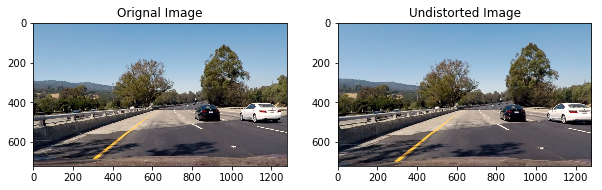

In [95]:
# Test the calibration

#test_img = mpimg.imread('test_sobel_image.jpg')
test_img = mpimg.imread('test_images/test4.jpg')
undistored_image = camera_calibration.undistort_image(test_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 10))
ax1.set_title('Orignal Image')
ax1.imshow(test_img)
ax2.set_title('Undistorted Image')
ax2.imshow(undistored_image)

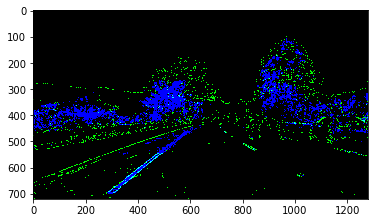

In [97]:
# Apply gradient and color thresholds

gradient_thresholded_image = GradientThresholdImage(undistored_image)
color_threshold_image = ColorThresholdImage(undistored_image)

gti_result = gradient_thresholded_image.get_gradient_threshold_combined()
cti_result = color_threshold_image.get_color_threshold_combined()

combined_image = get_color_gradient_combined(gti_result, cti_result)

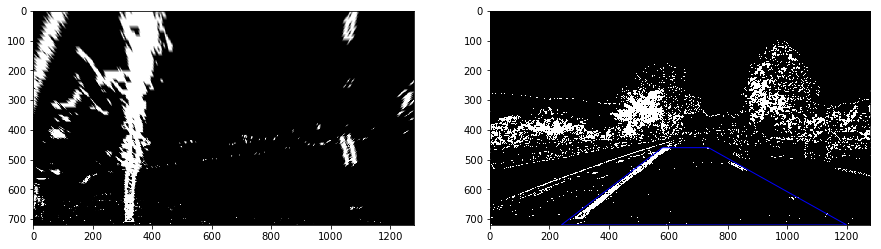

In [114]:
# Warp the image

warp_image = WarpImage(combined_image)
warped = warp_image.warp_image()
warp_image.draw_images(warped)

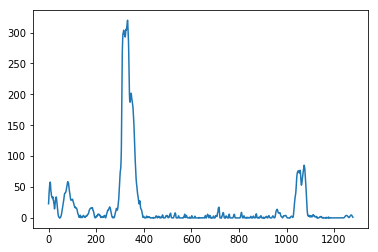

In [112]:
histogram = warp_image.get_image_histo(warped)
plt.plot(histogram)

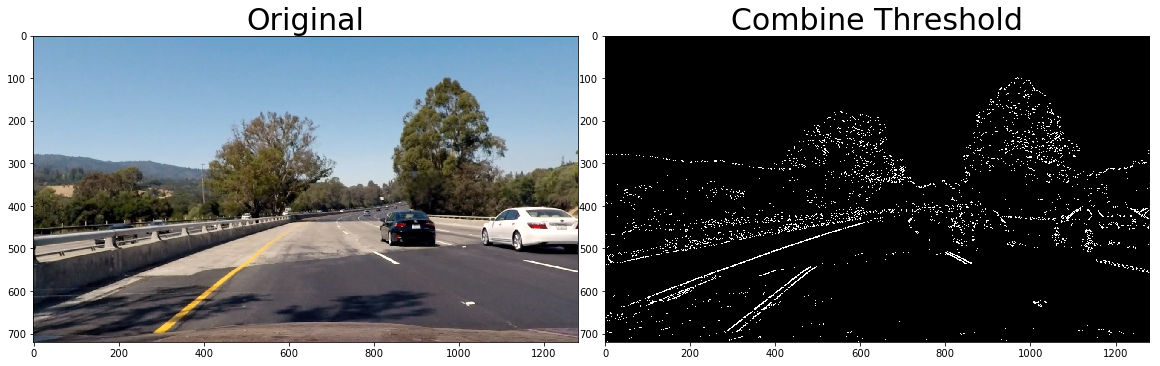

# Color Threshold (HLS)

In [10]:
hls = cv2.cvtColor(undistored_image, cv2.COLOR_RGB2HLS).astype(np.float)

H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]

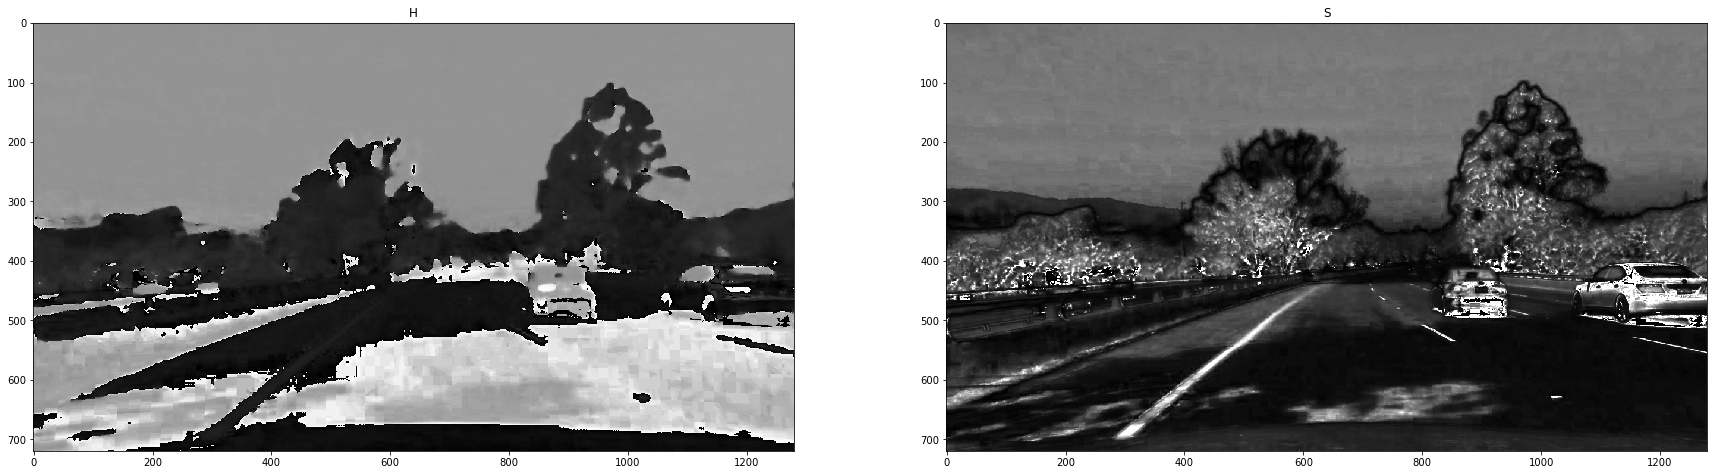

In [11]:
f, (ax1, ax3) = plt.subplots(1, 2, figsize=(30, 30))
ax1.set_title('H')
ax1.imshow(H, cmap='gray')
ax3.set_title('S')
ax3.imshow(S, cmap='gray')

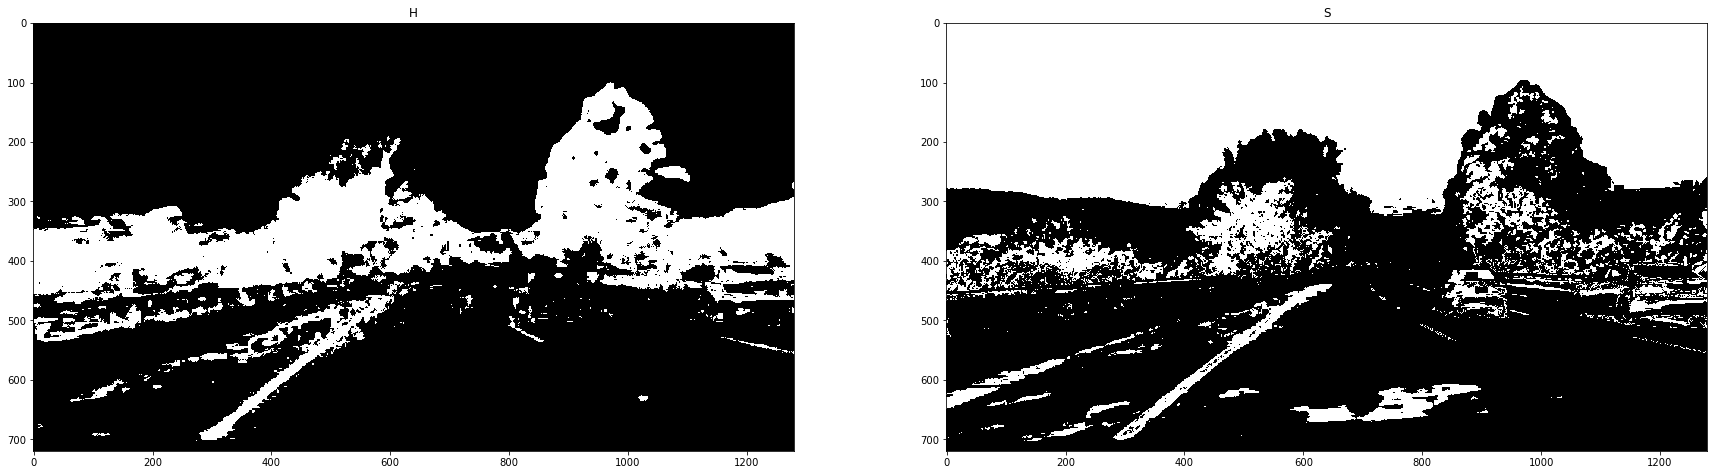

In [12]:
h_channel = np.zeros_like(H)
h_channel[(H > 15) & (H < 80)] = 1
s_channel = np.zeros_like(S)
s_channel[(S > 80) & (S < 255)] = 1

f, (ax1, ax3) = plt.subplots(1, 2, figsize=(30, 30))
ax1.set_title('H')
ax1.imshow(h_channel, cmap='gray')
ax3.set_title('S')
ax3.imshow(s_channel, cmap='gray')

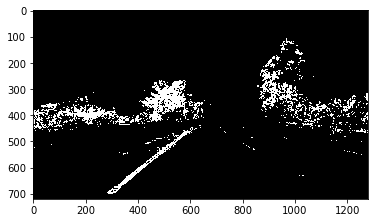

In [13]:
# Combine the two binary thresholds
color_combined = np.zeros_like(s_channel)
color_combined[(s_channel == 1) & (h_channel == 1)] = 1
plt.imshow(color_combined, cmap='gray')

# Combining Gradient and Color Thresholds

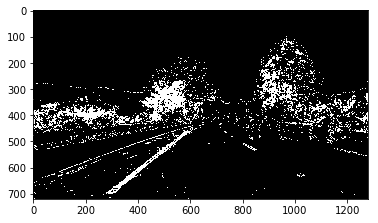

In [14]:
combined = np.zeros_like(s_channel)
combined[(grad_combined==1) | (color_combined==1)] = 1
plt.imshow(combined, cmap='gray')

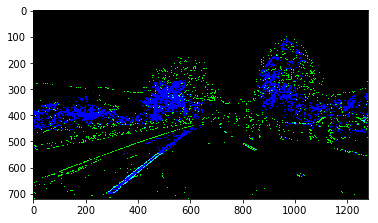

In [15]:
stack_image = np.dstack(( np.zeros_like(s_channel), grad_combined, color_combined))
plt.imshow(stack_image, cmap='gray')

# Warp the Image

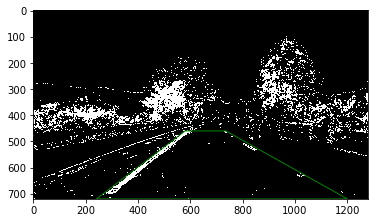

In [16]:
fig,ax = plt.subplots(1)
ax.imshow(combined, cmap='gray')
src = np.float32([[240,720],
                  [580,460],
                  [735,460],
                  [1200,720]])

# Create a Rectangle patch
rect = patches.Polygon(src, closed=True, fill=False, edgecolor='b')
ax.add_patch(rect)
plt.show()

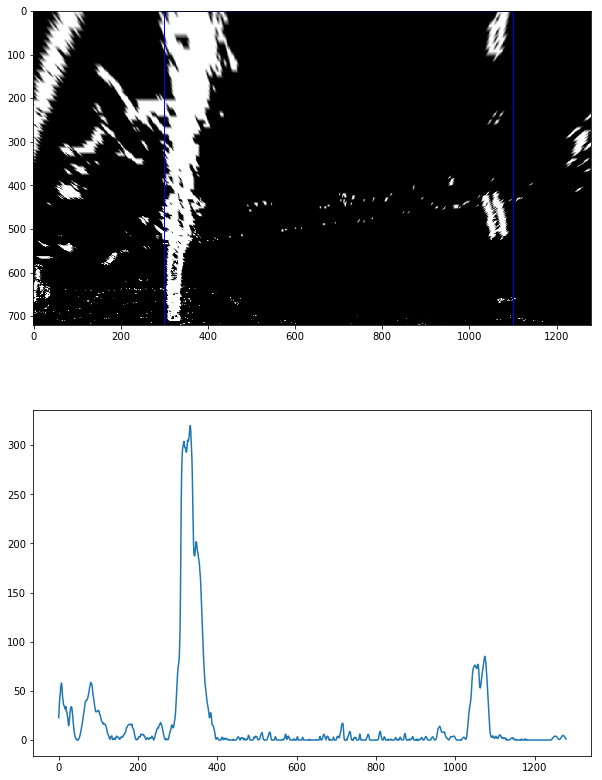

In [17]:
img_size = (combined.shape[1], combined.shape[0])
dst = np.float32([[300,720],
                  [300,0],
                  [1100,0],
                  [1100,720]])
M = cv2.getPerspectiveTransform(src, dst)
warped = cv2.warpPerspective(combined, M, img_size, flags=cv2.INTER_LINEAR)
histogram = np.sum(warped[int(warped.shape[0]/2):,:], axis=0)

fig, (ax, ax2) = plt.subplots(2, 1, figsize=(10,14))
ax.imshow(warped, cmap='gray')
rect = patches.Polygon(dst, closed=True, fill=False, edgecolor='b')
ax.add_patch(rect)
ax.imshow(warped, cmap='gray')
ax2.plot(histogram)
plt.show()

# Find the Lane Lines

In [59]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((warped, warped, warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
# aggingo midpoint perche' ottengo il max come differenza relativa rispetto al midpoint, per cui 
# per avere la posizione del massimo rispetto allo 0 dell'istogramma devo aggiungere il midpoint
rightx_base = np.argmax(histogram[midpoint:]) + midpoint
# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 10) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 10) 
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ( (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & 
                       (nonzerox < win_xleft_high) ).nonzero()[0]
    good_right_inds = ( (nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & 
                        (nonzerox < win_xright_high) ).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        
# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

### Visualize the result

(720, 0)

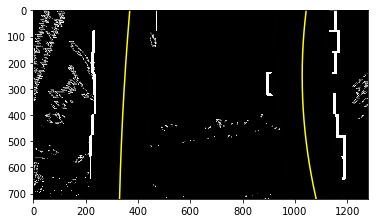

In [60]:
# Generate x and y values for plotting
ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

## Skip the sliding windows step once you know where the lines are

Now you know where the lines are you have a fit! In the next frame of video you don't need to do a blind search again, but instead you can just search in a margin around the previous line position like this:

In [61]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
margin = 100

left_lane_inds = ( (nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & 
                   (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)) ) 

right_lane_inds = ( (nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & 
                    (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)) )  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

The green shaded area shows where we searched for the lines this time. So, once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame. This is equivalent to using a customized region of interest for each frame of video, and should help you track the lanes through sharp curves and tricky conditions. If you lose track of the lines, go back to your sliding windows search or other method to rediscover them.

(720, 0)

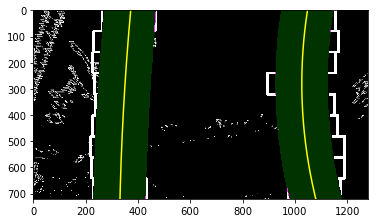

In [62]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)